In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import zscore
from scipy import stats
import seaborn as sns

In [2]:
def backtest_full(data, return_data, all_features, num_features = 5, num_funds=50, month=1, look_back=3, delay=5 , positioning = True, redemption_cost = 0.001, K = 1 , position_pct = 0.8):
    
    selected_features_all = []
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = []
    selected_funds = []
    
    df_out = pd.DataFrame(index = dates[look_back:-1:month])
    profit = 0
    cash = K * (1 - position_pct)
    holding = K * position_pct
    
    for i, date in enumerate(dates[look_back:-1:month]):
        
        print(i, date)
        pnl_period = quantile_delayed(data[(data.statistic_date >= dates[i-look_back]) & (data.statistic_date < date)], return_data[(return_data.statistic_date >= dates[i-look_back]) & (return_data.statistic_date < date)], all_features, num_funds=5, month=1, delay=5)
        features = top_features(pnl_period, num_features)
        selected_features_all.append(features)
        col = features+['fund_id', 'ret']
        df = data[data.statistic_date == date][col].dropna()
        df['score'] = stats.zscore(df[features]).sum(axis=1)
        ret = 0
        df = df.sort_values(by='score', ascending=False)
        funds = list(df.fund_id[:num_funds])
        selected_funds.append(funds)
        
        if positioning:
            size = np.array([max(1/(i+1) - 1/50,0) if len(funds) > 0 else 1 for i in range(len(funds))])
            if len(size) > 0:
                size = 1 / sum(size) * size
            else:
                size = 1
        else:
            size = [1 / num_funds for i in range(num_fund)]
        
        temp_df = return_data[(return_data.statistic_date >= (dates[look_back::month][i] + pd.Timedelta(str(delay)+'d'))) & (return_data.statistic_date <= (dates[look_back::month][i+1]  + pd.Timedelta(str(delay)+'d')))]
        temp_df = temp_df.loc[temp_df['fund_id'].isin(funds)]
        temp_df = pd.pivot_table(data=temp_df,index=['statistic_date'],columns= ['fund_id'],values=['added_nav'])
    
        
        if temp_df.shape[0] > 0:
            temp_ret = ((size) / temp_df.iloc[0] * temp_df).sum(axis=1)
            cost = 0.015/10 + 0.015/ 12 + redemption_cost
            profit = holding * (temp_ret.iloc[-1] * (1-cost) - 1)
            temp_perf = performance_matrix(pd.DataFrame(temp_ret).pct_change(),['sharpe','volatility','max_drawdown','var'],annualized_factor=252).T
            df_out.loc[date,'sharpe'] = temp_perf['sharpe'].values[0]
            df_out.loc[date,'volatility'] =  temp_perf['volatility'].values[0]
            df_out.loc[date,'max_drawdown'] = temp_perf['max_drawdown'].values[0]
            df_out.loc[date,'var'] = temp_perf['var'].values[0]
        else:
            profit = 0
        pnl.append(profit)   
        
        df_out.loc[date,'cash'] = cash + profit
        df_out.loc[date,'funds'] = str(funds)
        df_out.loc[date,'features'] = str(features)
        df_out.loc[date,'profit'] = profit
        
    return df_out

In [3]:
def quantile_delayed(data, return_data, features, num_funds=50, month=1, delay=5):
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months with delay
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for, delay (integer) - number of days it takes for us to buy funds
    output: a dict where keys are features and values are list of pnls over time
    '''
    
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = {}
    for feature in features:
        pnl[feature] = []
        for date in dates[::month]:
            df = data[(data.statistic_date == date) & (data[feature].isna() == False)].sort_values(by=feature, ascending=False)
            ret = 0
            funds = df.fund_id[:num_funds]
            
            # Iterate through funds and calculate t - month look ahead return
            for fund in funds:
                ret_per_fund = 1
                for i in range(month):
                    month_ret = return_data[(return_data.statistic_date == (date + pd.DateOffset(months=i)+pd.Timedelta(str(delay)+'d'))) & (return_data.fund_id == fund)].ret.values
                    if month_ret.size > 0:
                        ret_per_fund *= (1 + month_ret[0]/num_funds)
                    else:
                        break
                ret += ret_per_fund-1
            pnl[feature].append(ret)
    return pnl

In [4]:
def load_data(filename):
    data = pickle.load(open(filename, "rb"))
    data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric)
    data.statistic_date = pd.to_datetime(data.statistic_date)
    return data

In [5]:
# Sort features in terms of total cumulative pnl and pick top 20
def top_features(dic, top):
    cumul_pnl = {}
    for key, val in dic.items():
        cumul_pnl[key] = sum(val)
    
    sort_dic = dict(sorted(cumul_pnl.items(), key=lambda item: item[1]))
    return list(sort_dic.keys())[-top:]

In [6]:
def performance_matrix(df,metrics,annualized_factor = 12):

    performance_matrix = []
    for metric in metrics:
        if metric == 'mean':
            performance_matrix.append(df.mean() * annualized_factor)
        elif metric == 'volatility':
            performance_matrix.append(df.std() * np.sqrt(annualized_factor))
        elif metric == 'sharpe':
            performance_matrix.append(df.mean() * annualized_factor / (df.std() * np.sqrt(annualized_factor)))
        elif metric == 'skew':
            performance_matrix.append(df.skew())
        elif metric == 'excess_kurtosis':
            performance_matrix.append(df.kurtosis() - 3)
        elif metric == 'var':
            performance_matrix.append(df.quantile(0.05))
        elif metric =='cvar':
            performance_matrix.append(df[df < df.quantile(0.05)].mean())
        elif metric =='max_drawdown':
            cum_returns = (1 + df).cumprod()
            rolling_max = cum_returns.cummax()
            drawdown = (cum_returns - rolling_max) / rolling_max
            performance_matrix.append(drawdown.min())
        else:
            raise NoSuchMetricError( 'Metric ' + metric + ' is not valid!')
            
    performance_matrix = pd.concat(performance_matrix,axis=1)
    performance_matrix.columns = metrics

    return performance_matrix.T

In [7]:
def volitility_scaling(x):
    x = abs(x)
    if x > 2:
        return 0.0
    elif x > 0.2:
        return 0.5
    else:
        return 1

### Load Data

In [8]:
data = load_data('data_new.pickle')
df_ret = pd.read_pickle('ret.pickle')
df_csi = pd.read_pickle('benchmark.pickle')
optimal_features = pd.read_pickle('rf_optimal_features_monthly.pickle')
dates = sorted(data.statistic_date.unique())

### Compute Most Common Features

In [9]:
opt = [np.array(optimal_features[i]) for i in range(len(optimal_features))]
ordered_feat = Counter(np.concatenate(opt,axis=0)).most_common()
most_common_feat = [x[0] for x in ordered_feat if x[1]>5]

### Management Fee Distribution

Text(0.5, 1.0, 'Management Fee Distribution, Avg: 0.00944')

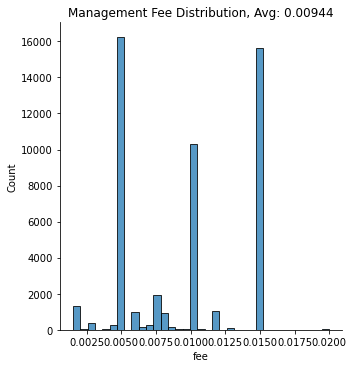

In [10]:
sns.displot(data.fee)
fee_avg = data.fee.mean()
plt.title('Management Fee Distribution, Avg: {fee}'.format(fee = round(fee_avg,5)))

### Risk Management Analysis

In [11]:
best_params_saved = {'look_back': 3, 'delay': 3, 'num_funds': 4, 'num_features': 11}

In [12]:
%%time
df_out = backtest_full(data, df_ret,  most_common_feat,month =1, redemption_cost= 0.005, position_pct= 0.8, **best_params_saved )

0 2017-04-30 00:00:00
1 2017-05-31 00:00:00
2 2017-06-30 00:00:00
3 2017-07-31 00:00:00
4 2017-08-31 00:00:00
5 2017-09-30 00:00:00
6 2017-10-31 00:00:00
7 2017-11-30 00:00:00
8 2017-12-31 00:00:00
9 2018-01-31 00:00:00
10 2018-02-28 00:00:00
11 2018-03-31 00:00:00
12 2018-04-30 00:00:00
13 2018-05-31 00:00:00
14 2018-06-30 00:00:00
15 2018-07-31 00:00:00
16 2018-08-31 00:00:00
17 2018-09-30 00:00:00
18 2018-10-31 00:00:00
19 2018-11-30 00:00:00
20 2018-12-31 00:00:00
21 2019-01-31 00:00:00
22 2019-02-28 00:00:00
23 2019-03-31 00:00:00
24 2019-04-30 00:00:00
25 2019-05-31 00:00:00
26 2019-06-30 00:00:00
27 2019-07-31 00:00:00
28 2019-08-31 00:00:00
29 2019-09-30 00:00:00
30 2019-10-31 00:00:00
31 2019-11-30 00:00:00
32 2019-12-31 00:00:00
33 2020-01-31 00:00:00
34 2020-02-29 00:00:00
35 2020-03-31 00:00:00
36 2020-04-30 00:00:00
37 2020-05-31 00:00:00
38 2020-06-30 00:00:00
39 2020-07-31 00:00:00
40 2020-08-31 00:00:00
41 2020-09-30 00:00:00
42 2020-10-31 00:00:00
43 2020-11-30 00:00:0

In [13]:
df = df_out.iloc[:-1]

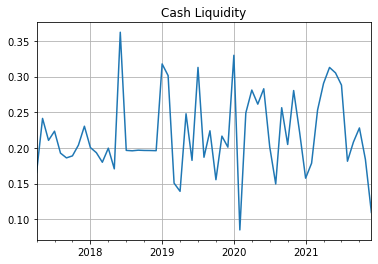

In [14]:
df.cash.plot()
plt.title('Cash Liquidity')
plt.grid()

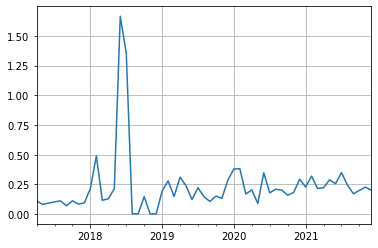

In [15]:
df.volatility.plot()
plt.grid()

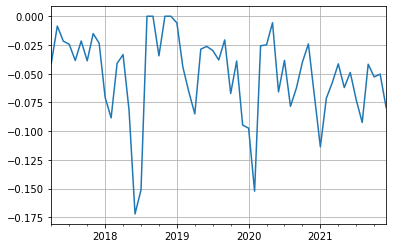

In [16]:
df.max_drawdown.plot()
plt.grid()

In [17]:
def pnl_with_risk_management(df):
    pass

In [18]:
df.ret = df.profit.cumsum()
cum_returns = (df.ret + 1)/ (df.ret[0] + 1)
rolling_max = cum_returns.cummax()
df['drawdown_monthly'] = (cum_returns - rolling_max) / rolling_max

/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_19731/252688794.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.ret = df.profit.cumsum()
/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_19731/252688794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['drawdown_monthly'] = (cum_returns - rolling_max) / rolling_max


In [29]:
position = 1
out = df[[]]
max_drawdown_daily = -0.1
max_drawdown_monthly = -0.1

daily_drawdown = 0
monthly_drawdown = 0

vol_z = (df.volatility - df.volatility.rolling(3,min_periods = 1).median())/df.volatility.std()

for i, row in df.iterrows():
    out.loc[i,'position'] = position
    out.loc[i,'profit'] = row.profit
    pnl = row.profit * position
    out.loc[i,'vol_factor'] = volitility_scaling(vol_z[i])
    out.loc[i,'pnl_factor'] = 1 if row.cash > 0 else 0
    
    out.loc[i,'daily_drawdown_factor'] = 1 if daily_drawdown < max_drawdown_daily  else 0
    out.loc[i,'monthly_drawdown_factor'] = 1 if monthly_drawdown < max_drawdown_monthly  else 0
    position = out.loc[i,'vol_factor'] * out.loc[i,'pnl_factor'] 
    
    daily_drawdown = row.max_drawdown
    monthly_drawdown = row.drawdown_monthly
    out.loc[i,'pnl'] = -0.1 if daily_drawdown < max_drawdown_daily else pnl
    out.loc[i,'pnl'] = -0.1 if monthly_drawdown < max_drawdown_monthly else pnl

out.monthly_drawdown_factor = out.monthly_drawdown_factor.shift(-1)

/Users/charles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/charles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/charles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [30]:
out['commission'] = (1 + out['pnl']) * (0.015/12)

/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_19731/920923595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out['commission'] = (1 + out['pnl']) * (0.015/12)


In [31]:
ret_raw = (1 + out['profit'].cumsum())
ret_rm = (1 + out['pnl'].cumsum())
ret_raw_commission = (1 + (out['profit'] - out['commission']).cumsum())
ret_rm_commission =  (1 + (out['pnl'] - out['commission']).cumsum())

In [32]:
strategy_names = ['Raw Strategy','Raw Strategy with Commission','With Risk Management','With Risk Management and Commission']

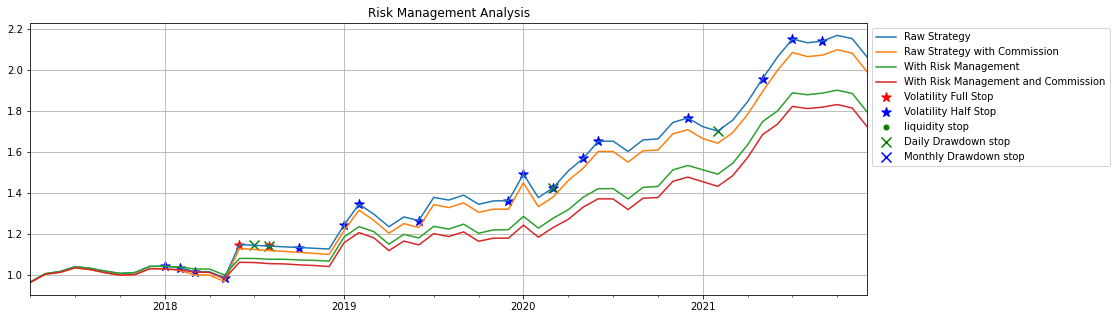

In [33]:
plt.subplots(figsize=(15,5))

ret_raw.plot(label= strategy_names[0])
ret_raw_commission.plot(label = strategy_names[1])
ret_rm.plot(label=strategy_names[2])
ret_rm_commission.plot(label =strategy_names[3])
vol_stop_full = out[out.vol_factor == 0]
vol_stop_half = out[out.vol_factor == 0.5]
liquid_stop = out[out.pnl_factor == 0]
daily_drawdown_stop = out[out.daily_drawdown_factor == 1]
monthly_drawdown_stop = out[out.monthly_drawdown_factor == 1]



plt.scatter(x=vol_stop_full.index, y=ret_raw[vol_stop_full.index],marker='*',color ='r',s = 100,label = 'Volatility Full Stop')
plt.scatter(x=vol_stop_half.index, y=ret_raw[vol_stop_half.index],marker='*',color ='b',s = 100,label = 'Volatility Half Stop')
plt.scatter(x=liquid_stop.index, y=ret_raw[liquid_stop.index],marker='.',color ='g',s = 100,label = 'liquidity stop')
plt.scatter(x=daily_drawdown_stop.index, y=ret_raw[daily_drawdown_stop.index],marker='x',color ='g',s = 100,label = 'Daily Drawdown stop')
plt.scatter(x=monthly_drawdown_stop.index, y=ret_raw[monthly_drawdown_stop.index],marker='x',color ='b',s = 100,label = 'Monthly Drawdown stop')
plt.legend()
plt.title('Risk Management Analysis')
plt.grid()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [34]:
metrics = ['mean','sharpe','max_drawdown','volatility','skew','excess_kurtosis','var','cvar']

In [35]:
df_perf = pd.concat([ret_raw,ret_raw_commission,ret_rm,ret_rm_commission],axis=1)
df_perf.columns = strategy_names

In [36]:
performance_matrix(df_perf.pct_change(),metrics = metrics).T

,mean,sharpe,max_drawdown,volatility,skew,excess_kurtosis,var,cvar
Raw Strategy,0.173740,1.200100,-0.081893,0.144771,1.021831,-0.837595,-0.038021,-0.055298
Raw Strategy with Commission,0.166761,1.124814,-0.085516,0.148256,1.000242,-0.947714,-0.039817,-0.057670
With Risk Management,0.139905,1.231846,-0.069182,0.113574,0.523492,-2.590493,-0.037944,-0.047607
With Risk Management and Commission,0.131643,1.127098,-0.072828,0.116798,0.514704,-2.634108,-0.040141,-0.050031


Text(0.5, 1.0, 'Strategy Position')

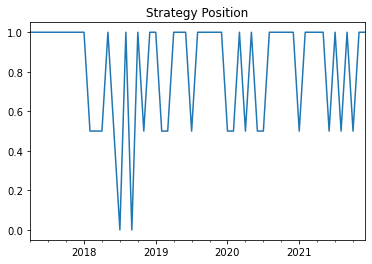

In [37]:
out.position.plot()
plt.title('Strategy Position')